In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [2]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_REKLAME.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2007-1,51218813,2007-01-01
1,2007-2,43617315,2007-02-01
2,2007-3,44434822,2007-03-01
3,2007-4,63832938,2007-04-01
4,2007-5,50442988,2007-05-01


In [3]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()
json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/reklame.json', 'w') as f:
    json.dump(json_data, f) 

{"2007-01-01T00:00:00.000":51218813,"2007-02-01T00:00:00.000":43617315,"2007-03-01T00:00:00.000":44434822,"2007-04-01T00:00:00.000":63832938,"2007-05-01T00:00:00.000":50442988,"2007-06-01T00:00:00.000":60939038,"2007-07-01T00:00:00.000":69081125,"2007-08-01T00:00:00.000":41267319,"2007-09-01T00:00:00.000":56015964,"2007-10-01T00:00:00.000":36703789,"2007-11-01T00:00:00.000":83725047,"2007-12-01T00:00:00.000":28035125,"2008-01-01T00:00:00.000":62759250,"2008-02-01T00:00:00.000":33086312,"2008-03-01T00:00:00.000":89685735,"2008-04-01T00:00:00.000":53949650,"2008-05-01T00:00:00.000":40407963,"2008-06-01T00:00:00.000":89835539,"2008-07-01T00:00:00.000":73304150,"2008-08-01T00:00:00.000":45376151,"2008-09-01T00:00:00.000":67775757,"2008-10-01T00:00:00.000":29970990,"2008-11-01T00:00:00.000":94469453,"2008-12-01T00:00:00.000":19584625,"2009-01-01T00:00:00.000":35198435,"2009-02-01T00:00:00.000":86907738,"2009-03-01T00:00:00.000":41955656,"2009-04-01T00:00:00.000":55387577,"2009-05-01T00:00:0

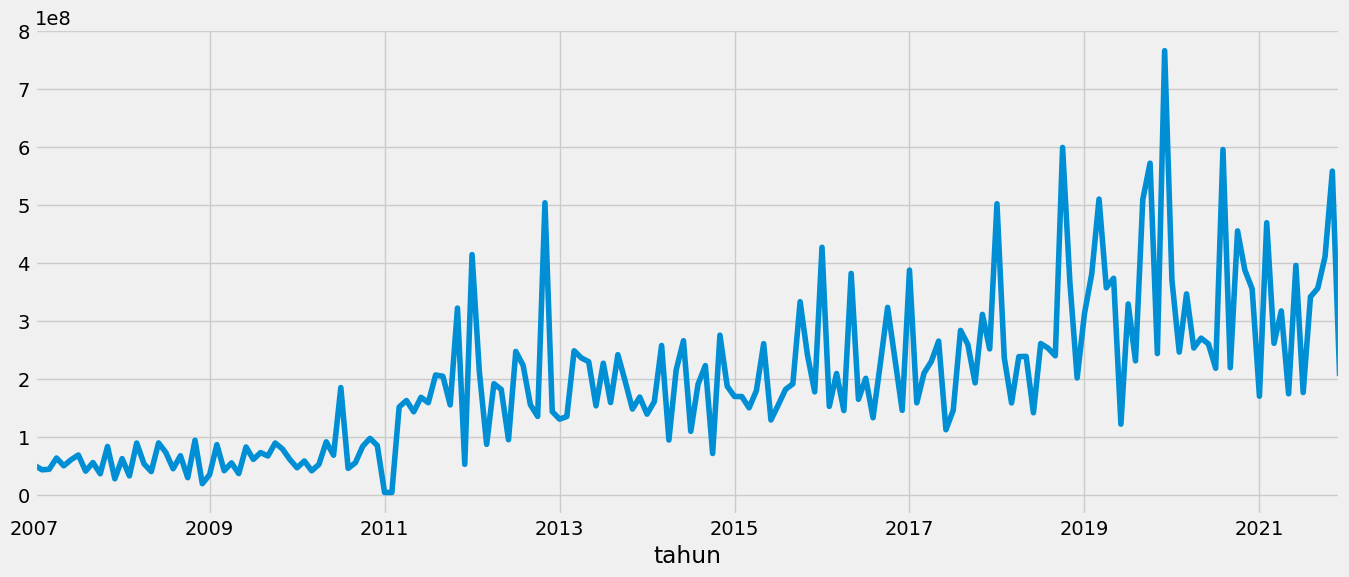

In [10]:
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [12]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 5
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [13]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = mod.fit()
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
print('\nBest Result:', best_result)


Best Result: [(1, 1, 1), (0, 1, 1, 12), 6673.586213222081]


In [ ]:
 #order=(1, 0, 0),
  #                          seasonal_order=(0, 0, 0, 12),
  #                          enforce_stationarity=False,
    #                        enforce_invertibility=False)

# Plot model diagnostics

In [4]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,order=(1, 0, 0),seasonal_order=(0, 1, 1, 12),
                            enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  180
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -3102.483
Date:                              Wed, 28 Dec 2022   AIC                           6210.966
Time:                                      08:17:37   BIC                           6220.096
Sample:                                  01-01-2007   HQIC                          6214.674
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0160      0.096      0.167      0.868      -0.173       0.205
ma.S.L12      -0.48

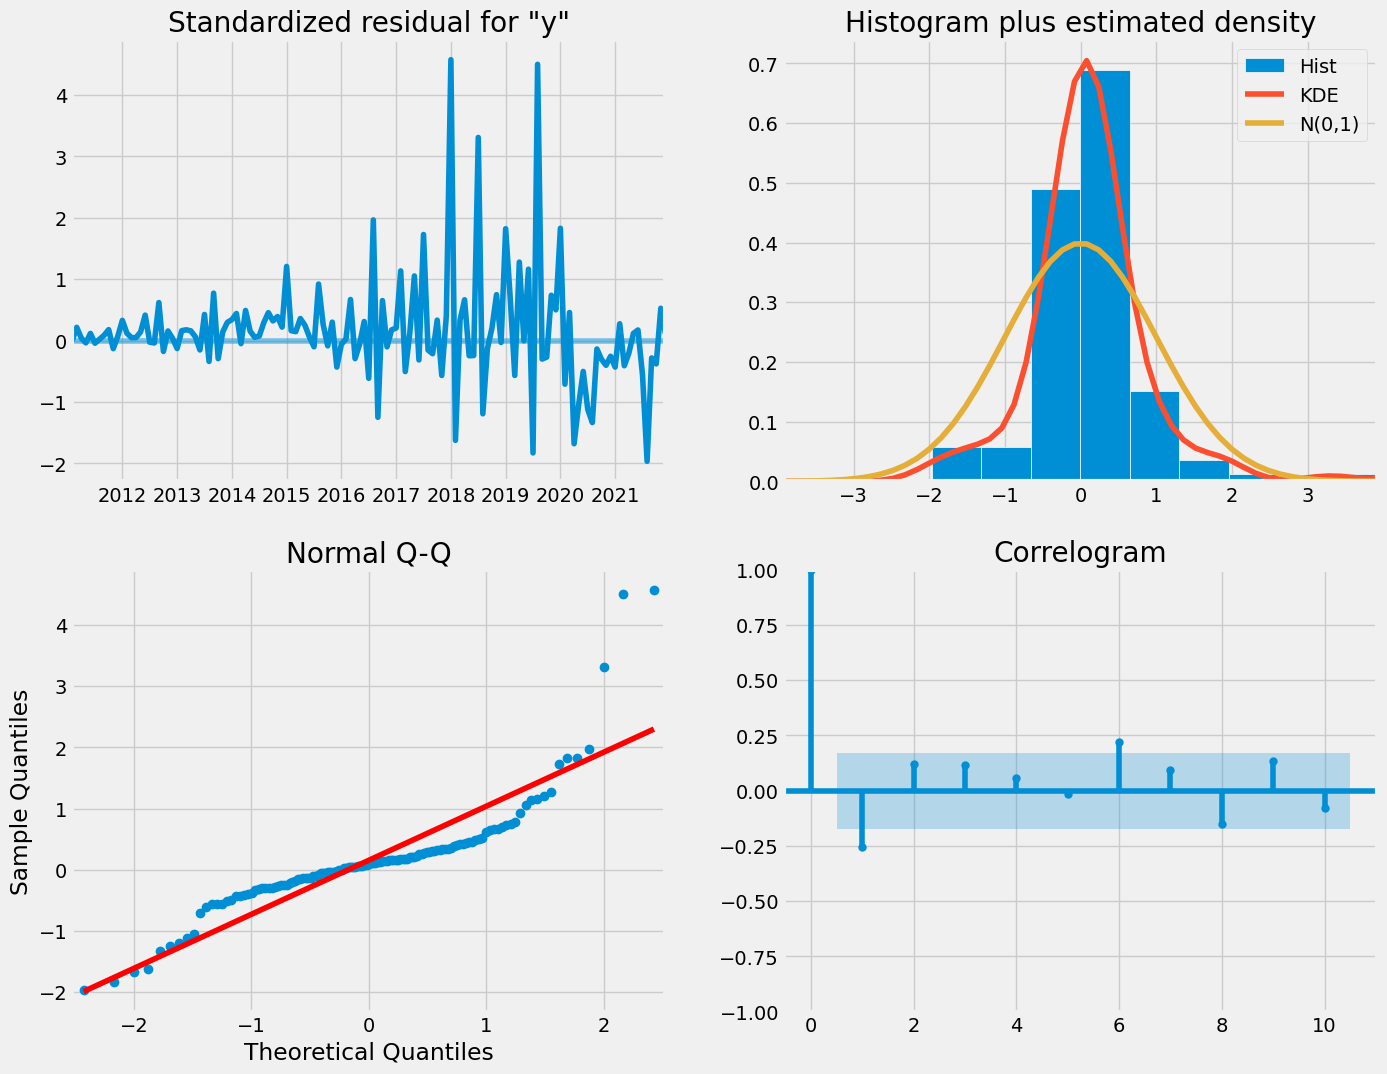

In [16]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

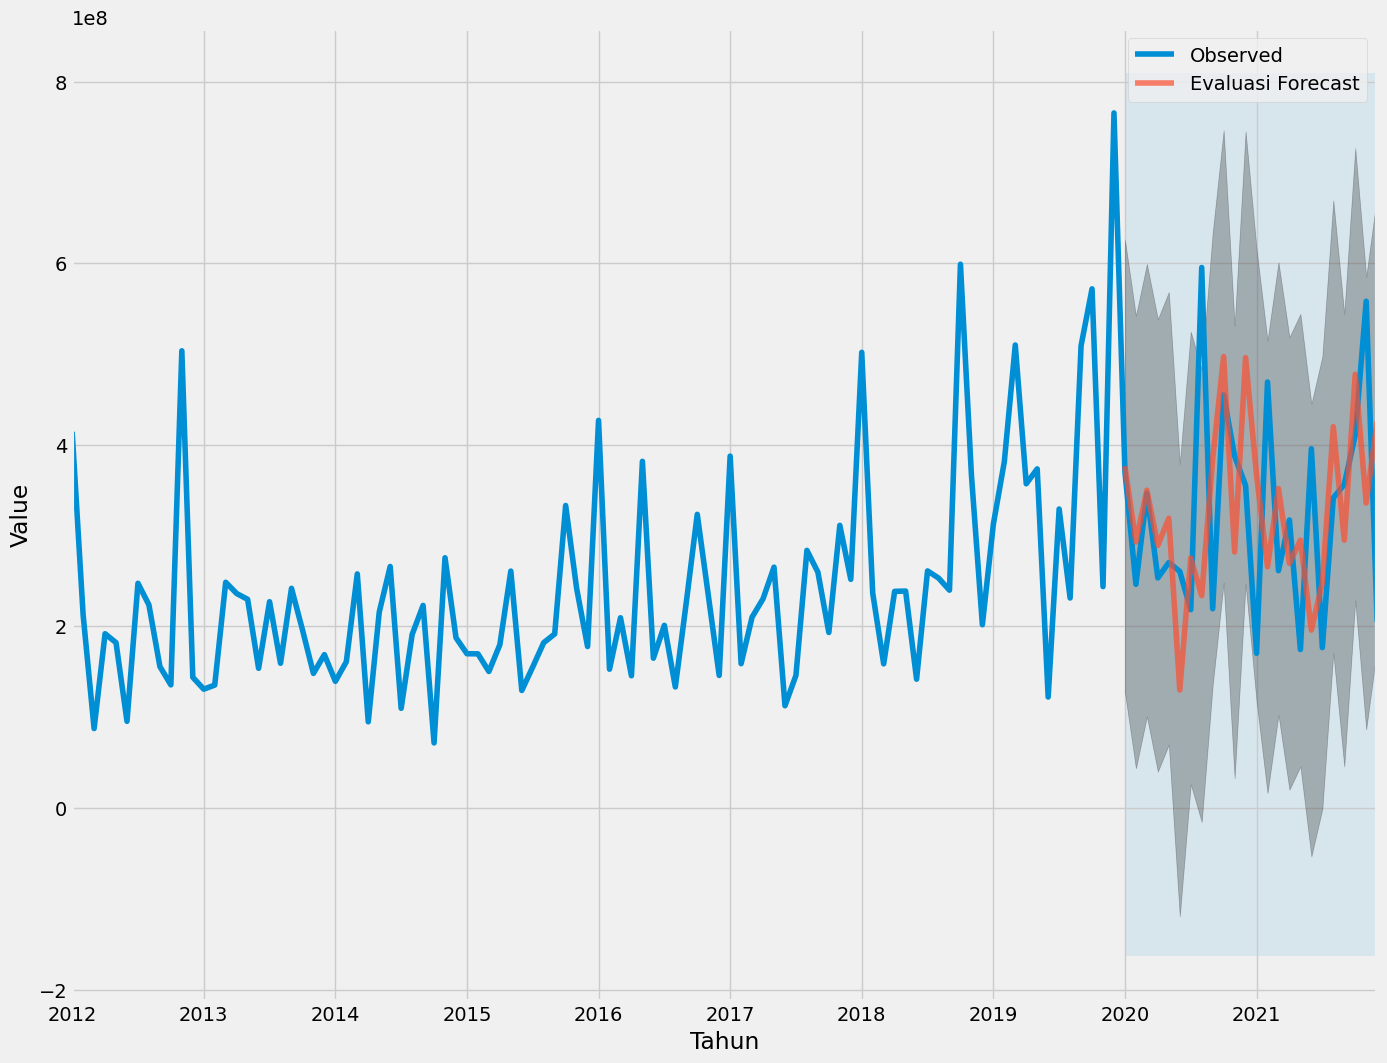

In [17]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()

# Prediksi data selama 2 tahun

In [6]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=60, dynamic=False)
# Dapatkan interval
pred_ci = pred_uc.conf_int()



json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/reklame_predicted.json', 'w') as f:
    json.dump(json_data, f) 

{"2022-01-01T00:00:00.000":262690302.6561895311,"2022-02-01T00:00:00.000":372221968.8547653556,"2022-03-01T00:00:00.000":303451908.9312980175,"2022-04-01T00:00:00.000":294685008.0136306286,"2022-05-01T00:00:00.000":232263628.0737500489,"2022-06-01T00:00:00.000":300013713.6629728079,"2022-07-01T00:00:00.000":209577550.3595589399,"2022-08-01T00:00:00.000":379857695.9049389362,"2022-09-01T00:00:00.000":327216716.0648320913,"2022-10-01T00:00:00.000":442460394.8634245992,"2022-11-01T00:00:00.000":451138586.8272373676,"2022-12-01T00:00:00.000":309989738.8257257938,"2023-01-01T00:00:00.000":264376443.929903388,"2023-02-01T00:00:00.000":372249029.9908506274,"2023-03-01T00:00:00.000":303452343.2395601273,"2023-04-01T00:00:00.000":294685014.9839095473,"2023-05-01T00:00:00.000":232263628.1856171191,"2023-06-01T00:00:00.000":300013713.6647681594,"2023-07-01T00:00:00.000":209577550.3595877588,"2023-08-01T00:00:00.000":379857695.9049394131,"2023-09-01T00:00:00.000":327216716.0648320913,"2023-10-01T0

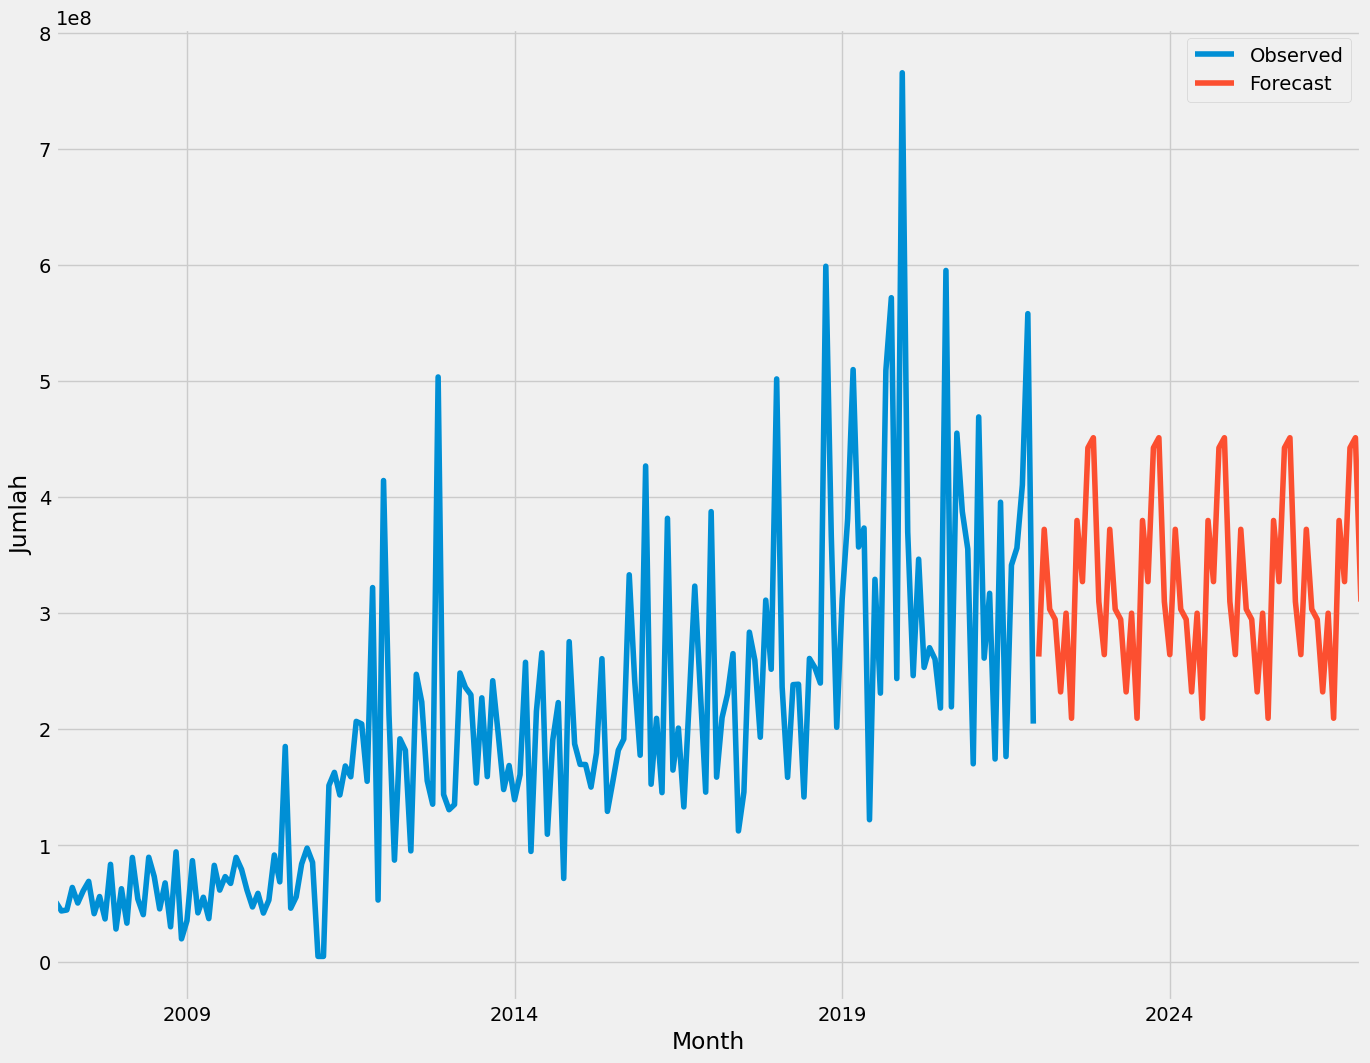

In [7]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()